<a href="https://colab.research.google.com/github/blancavazquez/CursoDatosMasivosII/blob/master/notebooks/4a_sisrec_contenido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de recomendación de películas
En esta libreta programaremos un sistema de recomendación de películas basado en contenido. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter

## Conjunto de datos MovieLens
Para ello usaremos la versión _small_ del conjunto de datos [MovieLens](https://grouplens.org/datasets/movielens/). Esta versión incluye 100,000 calificaciones y 3,600 etiquetas de 9,000 películas realizadas por 600 usarios distintos.


In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2021-01-17 21:29:56--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.50MB/s    in 0.6s    

2021-01-17 21:29:57 (1.50 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Cargamos las calificaciones, las etiquetas y las películas, las cuales se encuentran en archivos CSV.

In [3]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

Las etiquetas son asignadas por usuarios a una película. Un usuario puede etiquetar distintas películas y una pelicula puede estar etiquetada por múltiples usuarios.  

In [4]:
tags = tags.dropna()
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


Agrupamos las etiquetas por película. 

In [5]:
movietags = tags.groupby(['movieId'])['tag'].apply(set).reset_index(name='tags')
tagcount = Counter(t for r in movietags['tags'] for t in r)
print('{0} películas tienen al menos una etiqueta asociada por usuarios'.format(tags.shape[0]))
print('Hay {0} etiquetas distintas'.format(len(tagcount.keys())))
movietags.head()

3683 películas tienen al menos una etiqueta asociada por usuarios
Hay 1589 etiquetas distintas


,movieId,tags
0,1,"{pixar, fun}"
1,2,"{Robin Williams, magic board game, fantasy, game}"
2,3,"{old, moldy}"
3,5,"{remake, pregnancy}"
4,7,{remake}


Graficamos el histograma de número de etiquetas por película.

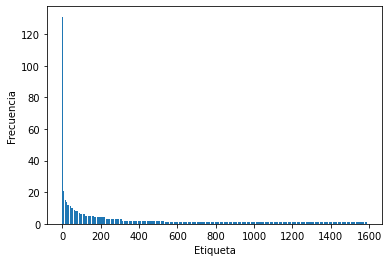

In [6]:
plt.bar(np.arange((len(tagcount.values()))), sorted(tagcount.values(), reverse=True))
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Frecuencia')
plt.show()

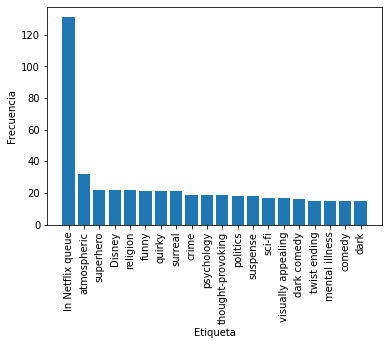

In [7]:
etiqs = [e[0] for e in tagcount.most_common(20)]
vals = [e[1] for e in tagcount.most_common(20)]
plt.bar(etiqs, vals)
plt.xticks(rotation='vertical')
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Frecuencia')
plt.show()

Exploramos las calificaciones y visualizamos sus histogramas.

In [8]:
ratings = ratings.dropna()
print('{0} calificaciones de usuarios a películas'.format(ratings.shape[0]))
ratings.head()

100836 calificaciones de usuarios a películas


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


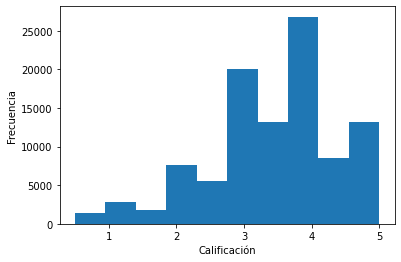

In [9]:
plt.hist(ratings['rating'])
plt.xlabel(u'Calificación')
plt.ylabel(u'Frecuencia')
plt.show()

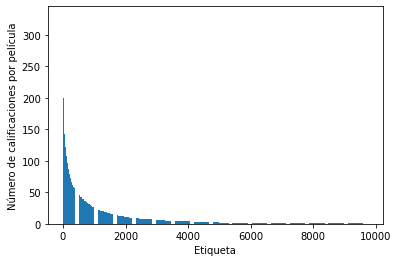

In [10]:
rvals = ratings.groupby(['movieId'])['rating'].size()
plt.bar(np.arange((len(rvals))), sorted(rvals, reverse=True))
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Número de calificaciones por película')
plt.show()

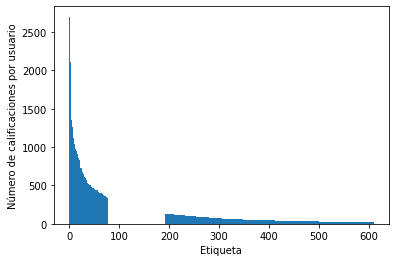

In [11]:
rvals = ratings.groupby(['userId'])['rating'].size()
plt.bar(np.arange((len(rvals))), sorted(rvals, reverse=True))
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Número de calificaciones por usuario')
plt.show()

Binarizamos las calificaciones: mayores o iguales a cuatro como _me gusta_ (1) y menores como _no me gusta_ (0).

In [12]:
pos = ratings['rating'] >= 4.0
binrates = np.zeros(ratings['rating'].shape[0])
binrates[pos.tolist()] = 1
ratings['like'] = binrates
ratings.head()

,userId,movieId,rating,timestamp,like
0,1,1,4.0,964982703,1.0
1,1,3,4.0,964981247,1.0
2,1,6,4.0,964982224,1.0
3,1,47,5.0,964983815,1.0
4,1,50,5.0,964982931,1.0


Visualizamos el histograma de las calificaciones binarizadas.

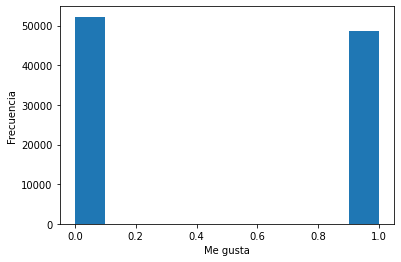

In [13]:
plt.hist(ratings['like'])
plt.xlabel(u'Me gusta')
plt.ylabel(u'Frecuencia')
plt.show()

Eliminamos valores faltantes de la tabla de películas, así como las películas sin género asignado (`(no genres listed)`).

In [14]:
movies = movies.dropna()
movies = movies[movies['genres']!='(no genres listed)']
print('{0} películas total'.format(movies.shape[0]))
movies.head()

9708 películas total


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Visualizamos los histogramas de géneros.

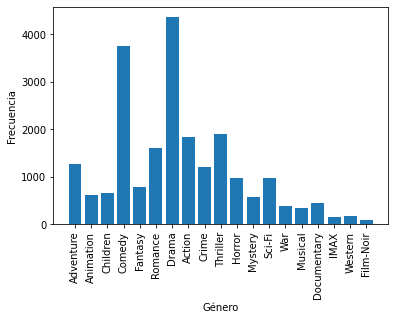

In [15]:
gcount = Counter(g for r in movies['genres'] for g in r.split('|'))
plt.bar(gcount.keys(), gcount.values())
plt.xticks(rotation='vertical')
plt.xlabel(u'Género')
plt.ylabel(u'Frecuencia')
plt.show()

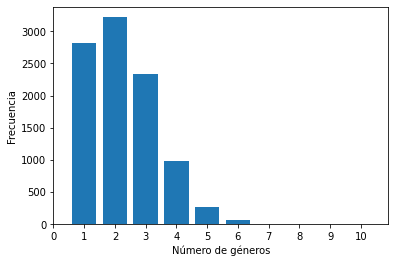

In [16]:
n_genres = Counter(len(r.split('|')) for r in movies['genres'])
plt.bar(n_genres.keys(), n_genres.values())
plt.xlabel(u'Número de géneros')
plt.ylabel(u'Frecuencia')
plt.xticks(range(11))
plt.show()

## Perfiles de películas

Convertimos la columna de géneros a múltiples variables binarias.

In [17]:
pelis = movies['genres'].str.get_dummies(sep='|')
pelis['movieId'] = movies['movieId']
pelis.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieId
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,4
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


## Perfiles de usuarios
Agrupamos todas las películas que le gustaron a un usuario en un solo registro y calculamos los perfiles de los usuarios como el promedio de las películas que le gustaron.

In [18]:
def promedio_usuario(calif, pelis):
  ids = calif['movieId']
  pelis_usuario = pelis.loc[pelis['movieId'].isin(ids)]
  pelis_usuario = pelis_usuario.drop('movieId', 1)
  return pelis_usuario.mean()

positivos = ratings[ratings['like']==1]
usuarios = positivos.groupby(['userId'])['movieId'].apply(list).reset_index(name='movieId')
perfiles_usuarios = positivos.groupby(['userId']).apply(promedio_usuario, pelis)

Desplegamos los primeros registros de la tabla de las películas agrupadas por usuario 

In [19]:
usuarios.head()

,userId,movieId
0,1,"[1, 3, 6, 47, 50, 101, 110, 151, 157, 163, 216..."
1,2,"[333, 1704, 3578, 6874, 46970, 48516, 58559, 6..."
2,3,"[849, 1587, 2288, 2851, 3024, 3703, 4518, 5181..."
3,4,"[106, 125, 162, 176, 215, 232, 260, 265, 319, ..."
4,5,"[1, 21, 34, 36, 50, 58, 110, 232, 247, 261, 29..."


Examinamos los perfiles de usuario calculados.

In [20]:
print(perfiles_usuarios)

          Action  Adventure  Animation  ...  Thriller       War   Western
userId                                  ...                              
1       0.380000   0.370000   0.135000  ...  0.215000  0.100000  0.030000
2       0.368421   0.105263   0.000000  ...  0.315789  0.052632  0.000000
3       0.562500   0.250000   0.000000  ...  0.375000  0.000000  0.000000
4       0.101562   0.148438   0.031250  ...  0.171875  0.039062  0.054688
5       0.130435   0.130435   0.217391  ...  0.217391  0.086957  0.043478
...          ...        ...        ...  ...       ...       ...       ...
606     0.092985   0.114192   0.039152  ...  0.145188  0.063622  0.009788
607     0.378378   0.180180   0.018018  ...  0.423423  0.036036  0.018018
608     0.396429   0.221429   0.060714  ...  0.403571  0.035714  0.003571
609     0.100000   0.200000   0.000000  ...  0.400000  0.200000  0.100000
610     0.350163   0.203583   0.061889  ...  0.351792  0.039088  0.024430

[609 rows x 19 columns]


## Búsqueda de películas a recomendar
Para encontrar películas con perfil similar a un perfil de usuario usaremos hnswlib, una biblioteca escalable para la búsqueda del vecino más cercano aproximado.

In [21]:
!pip install hnswlib
import hnswlib

     |████████████████████████████████| 194kB 16.6MB/s 
  ERROR: Failed building wheel for hnswlib
  Running setup.py clean for hnswlib
Failed to build hnswlib
    Running setup.py install for hnswlib ... done


Seleccionamos un usuario para recomendarle películas.

In [22]:
uid = 1
pelis_u1 = usuarios[usuarios['userId']==uid]['movieId']
print(pelis_u1)

0    [1, 3, 6, 47, 50, 101, 110, 151, 157, 163, 216...
Name: movieId, dtype: object


Buscamos las películas cuyos perfiles son más similares al perfil del usuario (similitud coseno).

In [23]:
uid = 1
perfiles_pelis_u1 = pelis[~pelis['movieId'].isin(pelis_u1[0])]
mids_u1 = perfiles_pelis_u1['movieId']
perfiles_pelis_u1 = perfiles_pelis_u1.drop('movieId', 1)
consulta = perfiles_usuarios.loc[uid].to_numpy()[np.newaxis]
ann = hnswlib.Index(space = 'cosine', dim = perfiles_usuarios.shape[1])
ann.init_index(max_elements = perfiles_pelis_u1.shape[0], ef_construction = 200, M = 16)
ann.add_items(perfiles_pelis_u1.to_numpy(), mids_u1.to_numpy())
vecinos, dists = ann.knn_query(consulta, k = 10)

Desplegamos las películas ordenadas por similitud coseno.

In [24]:
print(movies[movies['movieId'].isin(vecinos[0])])

      movieId  ...                                           genres
3608     4956  ...   Action|Adventure|Comedy|Drama|Romance|Thriller
4005     5657  ...              Action|Adventure|Comedy|Crime|Drama
4681     6990  ...              Action|Adventure|Comedy|Crime|Drama
5379     8968  ...           Action|Adventure|Comedy|Crime|Thriller
5471    26184  ...           Action|Adventure|Comedy|Crime|Thriller
6094    42015  ...            Action|Adventure|Comedy|Drama|Romance
6570    55116  ...           Action|Adventure|Comedy|Drama|Thriller
7409    80219  ...           Action|Adventure|Comedy|Crime|Thriller
8597   117646  ...   Action|Adventure|Comedy|Drama|Fantasy|Thriller
9394   164226  ...  Action|Adventure|Comedy|Fantasy|Sci-Fi|Thriller

[10 rows x 3 columns]
